In [1]:
import sys
sys.path.append('../')

In [2]:
import numpy
import xarray
import dask
import hrlam
import matplotlib.pyplot as plt
import climtas.nci

In [3]:
climtas.nci.GadiClient()

Client Scheduler: tcp://127.0.0.1:38535 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


In [4]:
hrlam.stream_vars('spec')

['aero_r',
 'mid_cld',
 'sfc_pres',
 'spec_hum',
 'ttl_col_qcf',
 'ttl_cld',
 'hi_cld',
 'uwnd10m',
 'tiles_pot_et',
 'wndgust10m',
 'max_refl',
 'temp_scrn',
 'abl_ht',
 'n_lightning_fl',
 'vwnd10m',
 'sfc_temp',
 'tiles_r_evap',
 'pressure',
 'low_cld',
 'ttl_col_qcl',
 'tiles_coeffs_ratio',
 'storm_loc_flag',
 'ttl_col_dry_mass',
 'accum_ls_snow',
 'accum_ls_prcp',
 'max_wndgust10m',
 'qsair_scrn',
 'mslp',
 'flash_rate',
 'ttl_col_wet_mass',
 'dewpt_scrn']

In [9]:
def var_stats(var, bound=200):
    var = var.isel(latitude=slice(bound,-1-bound),longitude=slice(bound,-1-bound))
    
    dims = ['latitude', 'longitude']
    amin, amax, amean, astd = dask.compute(var.min(dims).data, var.max(dims).data, var.mean(dims).data, var.std(dims).data)
    return xarray.Dataset({'min': ('time', amin), 'max': ('time', amax), 'mean': ('time', amean), 'std': ('time', astd)}, coords={'time': var.time})

In [6]:
def open_expt_var(stream, var, expt='400m'):
    """
    Open a variable
    """
    assert expt in ['400m', 'BARRA_R', 'BARRA_SY', 'BARRA_TA']
    if expt=='400m':
        return hrlam.open_var(stream, var)
    if expt.startswith('BARRA'):
        from glob import glob
        paths = sorted(glob(f'/g/data/ua8/HighResLAM/BARRA/{expt}/{var}-fc-{stream}-PT10M-BARRA_R-v1-*.nc'))
        dss = [xarray.open_dataset(p, chunks={'time': -1}).isel(time=slice(0,6*6)) for p in paths]
        
        return xarray.concat(dss, dim='time')[var]
    raise Exception(f'{expt}, {stream}, {var} not found')

In [7]:
def plot_spec_stats(var):
    d0036 = open_expt_var('spec', var, expt='400m')
    barra = open_expt_var('spec', var, expt='BARRA_R')
    barra = barra.sel(latitude=slice(d0036.latitude[0], d0036.latitude[-1]))
    barra = barra.sel(longitude=slice(d0036.longitude[0], d0036.longitude[-1]))
    barra = barra.sel(time=slice(d0036.time[0], d0036.time[-1]))
    d0036_stats = var_stats(d0036, bound=200)
    barra_stats = var_stats(barra, bound=0)
    
    def plot_stats(stats, color, label):
        print(stats)
        plt.plot(stats.time, stats['mean'], '-', color=color, label=label)
        #plt.fill_between(stats.time, stats['mean']+stats['std'], stats['mean']-stats['std'], color=color, alpha=0.3)
        plt.plot(stats.time, stats['min'], ':', color=color)
        plt.plot(stats.time, stats['max'], ':', color=color)
        
    plot_stats(d0036_stats, 'tab:blue', '400m')
    plot_stats(barra_stats, 'tab:orange', 'BARRA_R')
    plt.legend()
    plt.title(f'{d0036.name} - {d0036.attrs["long_name"]}')

In [8]:
%%time

for var in ['dewpt_scrn', 'hi_cld', 'low_cld', 'mid_cld', 'mslp', 'temp_scrn', 'ttl_cld', 'uwind10m', 'vwind10m', 'wndgust10m']:
    print(var)
    plt.figure(figsize=(10,5))
    plot_spec_stats(var)
    plt.savefig(f'qc_stats_{var}.png')
    plt.close()

dewpt_scrn
<xarray.Dataset>
Dimensions:                  (time: 354)
Coordinates:
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    height                   float64 1.5
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2017-03-26T12:10:00 ... 2017-03-28T23:00:00
Data variables:
    min                      (time) float32 268.67148 268.97784 ... 259.68262
    max                      (time) float32 305.88403 305.82324 ... 302.083
    mean                     (time) float32 289.58115 289.5827 ... 287.79892
    std                      (time) float32 6.506883 6.50667 ... 8.094494
<xarray.Dataset>
Dimensions:                  (time: 354)
Coordinates:
    height                   float64 1.5
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(36,), meta=np.ndarray>
    forecast_reference_time  (time) datetime64[ns] 2017-03-26T12:00:00 ... 2017-03-28T18:00:

OSError: no files to open

<Figure size 720x360 with 0 Axes>

In [9]:
d0036 = open_expt_var('spec', 'mslp', expt='400m')
barra = open_expt_var('spec', 'mslp', expt='BARRA_R')

barra = barra.sel(latitude=slice(d0036.latitude[0], d0036.latitude[-1]))
barra = barra.sel(longitude=slice(d0036.longitude[0], d0036.longitude[-1]))
barra = barra.sel(time=slice(d0036.time[0], d0036.time[-1]))

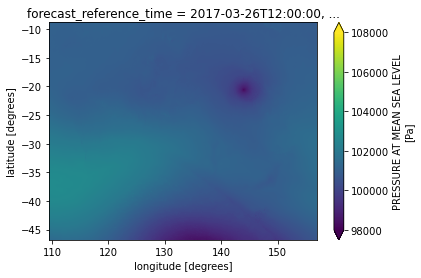

In [10]:
d0036[-1,...].plot.imshow(vmin=98000, vmax=108000)

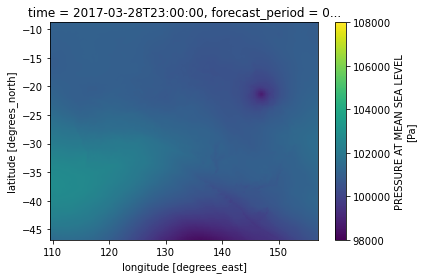

In [11]:
barra[-1,...].plot.imshow(vmin=98000, vmax=108000)

In [16]:
! montage -geometry +2+2 -tile 3x3 qc_stats_*.png montage_qc_stats.png

In [5]:
temp_scrn = hrlam.open_expt_var('spec', 'temp_scrn', expt='400m')

In [10]:
var_stats(temp_scrn.sel(time=slice(None, '20170326T1800')))

<xarray.Dataset>
Dimensions:                  (time: 36)
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2017-03-26T12:10:00 ... 2017-03-26T18:00:00
Data variables:
    min                      (time) float32 280.10187 279.84662 ... 276.79382
    max                      (time) float32 313.66666 313.56744 ... 310.01138
    mean                     (time) float32 296.95715 296.8961 ... 295.4459
    std                      (time) float32 6.969143 6.937872 ... 6.3856354

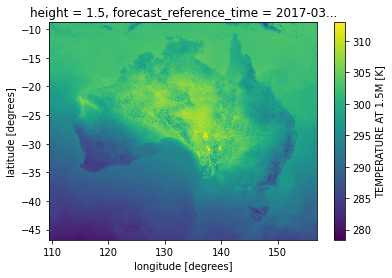

In [15]:
temp_scrn.isel(time=8).plot.imshow()

In [17]:
numpy.where(temp_scrn.isel(time=7) > 350)

(array([3423]), array([8680]))

In [18]:
temp_scrn[7,3423,8680]

<xarray.DataArray 'temp_scrn' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    latitude                 float32 -34.4744
    longitude                float64 140.8
    time                     datetime64[ns] 2017-03-26T13:20:00
    forecast_period          timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    standard_name:           air_temperature
    units:                   K
    source:                  Data from Met Office Unified Model
    um_version:              11.4
    STASH:                   [  1   3 236]
    um_stash_source:         m01s03i236
    long_name:               TEMPERATURE AT 1.5M
    stash_code:              3236
    wgdos_packing_accuracy:  2^-6
    stash_comments:          Estimate of atmospheric temperature (K) at 1.5m ...
    stash_description:       TEMPERATURE AT 1.5M
    description:             Atmospheric air temperature at 1.5m above ground...

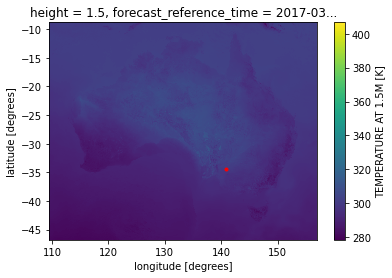

In [22]:
temp_scrn.isel(time=7).plot.imshow()
plt.plot([140.8], [-34.4744], '.r')
plt.savefig('temp_scrn_outlier.png')

In [24]:
dew_scrn = hrlam.open_expt_var('spec', 'dewpt_scrn', expt='400m')

In [25]:
var_stats(dew_scrn.sel(time=slice(None, '20170326T1800')))

<xarray.Dataset>
Dimensions:                  (time: 36)
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2017-03-26T12:10:00 ... 2017-03-26T18:00:00
Data variables:
    min                      (time) float32 268.67148 268.97784 ... 262.09088
    max                      (time) float32 305.88403 305.82324 ... 302.29144
    mean                     (time) float32 289.58115 289.5827 ... 289.55475
    std                      (time) float32 6.506883 6.50667 ... 6.3975277

In [27]:
Out[25]['min'].values[24]

0.0

In [28]:
numpy.where(dew_scrn[24,:,:] < 200)

(array([5764]), array([6366]))

In [29]:
dew_scrn[24,5764,6366]

<xarray.DataArray 'dewpt_scrn' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    latitude                 float32 -26.046799
    longitude                float64 132.4
    time                     datetime64[ns] 2017-03-26T16:10:00
    forecast_period          timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    standard_name:           dew_point_temperature
    units:                   K
    source:                  Data from Met Office Unified Model
    um_version:              11.4
    STASH:                   [  1   3 250]
    um_stash_source:         m01s03i250
    long_name:               DEWPOINT AT 1.5M (K)
    stash_code:              3250
    wgdos_packing_accuracy:  2^-6
    description:             Dewpoint temperature at 1.5m above ground level ...

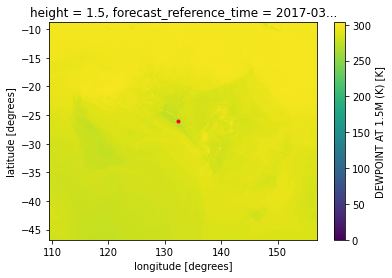

In [31]:
dew_scrn.isel(time=24).plot.imshow()
plt.plot([132.4], [-26.046799], '.r')
plt.savefig('dew_scrn_outlier.png')

In [32]:
var_stats(dew_scrn.sel(time=slice('20170328T0600', '20170328T0800')))

<xarray.Dataset>
Dimensions:                  (time: 13)
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    forecast_period          (time) timedelta64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2017-03-28T06:00:00 ... 2017-03-28T08:00:00
Data variables:
    min                      (time) float32 265.5968 264.8997 ... 267.1491
    max                      (time) float32 304.87723 305.11096 ... 307.5683
    mean                     (time) float32 287.69818 287.69354 ... 287.83752
    std                      (time) float32 7.6152835 7.6319714 ... 7.72082

In [36]:
Out[32]['min'][5]

<xarray.DataArray 'min' ()>
array(0., dtype=float32)
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    forecast_period          timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
    time                     datetime64[ns] 2017-03-28T06:50:00

In [42]:
numpy.where(dew_scrn.sel(time='20170328T0650') < 200)

(array([9972, 9975]), array([8791, 8794]))

In [43]:
dew_scrn.sel(time='20170328T0650')[9972, 8791]

<xarray.DataArray 'dewpt_scrn' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    latitude                 float32 -10.897999
    longitude                float64 141.2
    time                     datetime64[ns] 2017-03-28T06:50:00
    forecast_period          timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    standard_name:           dew_point_temperature
    units:                   K
    source:                  Data from Met Office Unified Model
    um_version:              11.4
    STASH:                   [  1   3 250]
    um_stash_source:         m01s03i250
    long_name:               DEWPOINT AT 1.5M (K)
    stash_code:              3250
    wgdos_packing_accuracy:  2^-6
    description:             Dewpoint temperature at 1.5m above ground level ...

In [44]:
dew_scrn.sel(time='20170328T0650')[9975, 8794]

<xarray.DataArray 'dewpt_scrn' ()>
dask.array<getitem, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    height                   float64 1.5
    forecast_reference_time  datetime64[ns] 2017-03-26T12:00:00
    latitude                 float32 -10.887199
    longitude                float64 141.2
    time                     datetime64[ns] 2017-03-28T06:50:00
    forecast_period          timedelta64[ns] dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    standard_name:           dew_point_temperature
    units:                   K
    source:                  Data from Met Office Unified Model
    um_version:              11.4
    STASH:                   [  1   3 250]
    um_stash_source:         m01s03i250
    long_name:               DEWPOINT AT 1.5M (K)
    stash_code:              3250
    wgdos_packing_accuracy:  2^-6
    description:             Dewpoint temperature at 1.5m above ground level ...

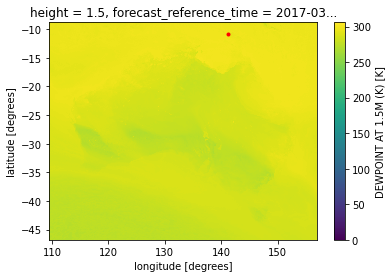

In [45]:
dew_scrn.sel(time='20170328T0650').plot.imshow()
plt.plot([141.2], [-10.897999], '.r')
plt.savefig('dew_scrn_outlier2.png')

In [22]:
def qc_time_axis(var):
    delta = var.time.diff('time') 
    mx = delta.max().values
    mn = delta.min().values
    if mx - mn > numpy.timedelta64(10,'ms'):
        print("Error in",var.name, "Max step", mx, "Min step", mn)

In [23]:
for var in hrlam.stream_vars('spec'):
    v = hrlam.open_d0036_var('spec', var)
    qc_time_axis(v)

In [4]:
v = hrlam.open_expt_var('spec', 'sfc_pres', expt='400m')

In [5]:
stats = hrlam.basic_stats(v, exclude_boundary=200)

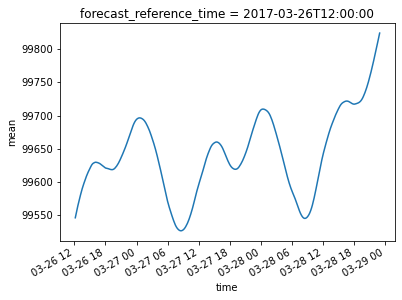

In [6]:
stats['mean'].plot()

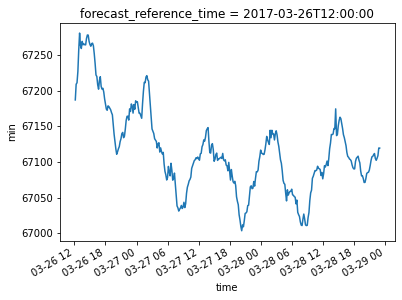

In [7]:
stats['min'].plot()

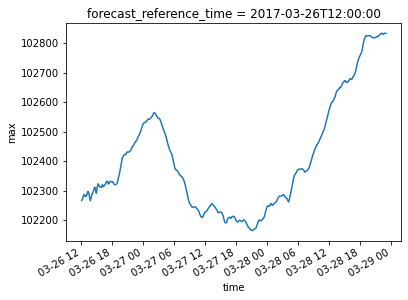

In [8]:
stats['max'].plot()

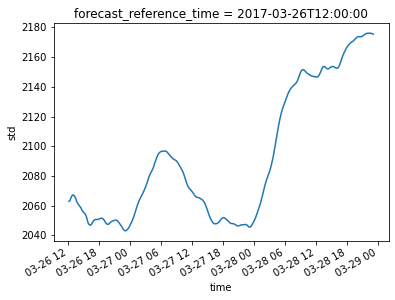

In [9]:
stats['std'].plot()

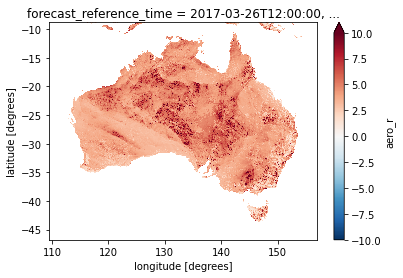

In [16]:
numpy.log(v[0,...]).plot.imshow(vmax=10)

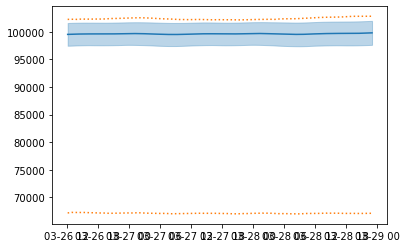

In [10]:
plt.plot(stats.time, stats['mean'], '-', color='tab:blue')
plt.fill_between(stats.time, stats['mean']+stats['std'], stats['mean']-stats['std'], color='tab:blue', alpha=0.3)
plt.plot(stats.time, stats['min'], ':', color='tab:orange')
plt.plot(stats.time, stats['max'], ':', color='tab:orange')